**Исследование объявлений о продаже квартир**

У нас в наличии есть архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

Цель - научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры, которые влияют на стоимость. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. 
Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Будем следовать вледующему плану:
- [Загрузим нужные библиотеку и исследуем первичную информацию](#1)
- [Предобработаем данные (заполним пропуски, приведем типы, добавим нужную информацию)](#2)
- [Проведем исследовательский анализ данных](#3)
- [Сделаем общий вывод](#4)

## Загрузка данных и первичный обзор 
<a id='1'></a>

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


Теперь ознакомимся с первичной информацией о датасете

In [2]:
df = pd.read_csv('C:\\Users\\Александр\Datasets/real_estate_data.csv', sep = '\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Исходя из общей информации делаем вывод, что нам нужно поработать над следующими направлениями:
- заполнить пустые значения там, где это возможно
- определить причины пропусков и понять, как их обработать
- привести данные к нужным нам типам
- выявить возможные дубликаты 
- добавить значения (столбцы), нужные нам для анализа

##  Предобработка данных
<a id='2'></a>

Сначала заполним пустые значения в столбце ceiling_height (высота потолков). Поскольку существуют определенные стандарты высоты жилых помещений - заполним пропущенные значения медианой и проверим, остались ли пропуски

In [3]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
display(df['ceiling_height'].isna().sum())
#display(df.info())

0

Пропущенные значения в ячейках с floors_total нам не заполнить, поэтому отбросим их и не будем учитывать при дальнейших расчетах (таких ячеек - 0,3%)

In [4]:
df = df[~df['floors_total'].isna()]

Теперь нам надо разобраться с пропусками в столбцах с жилой и нежилой (кухня) площадью. Общая площадь будет высчитываться по формуле: общая = жилая + кухонная. Но есть риск, что при заполнении столбца жилой площади медианой по количеству комнат окажется, что жилая площадь больше кухонной. Поэтому предлагаем рассчитать для каждой группы медиану отношения жилой площади к общей, а уже исходя из этой медианы заполнить пропуски

In [5]:
df['liv/total_area'] = df['living_area'] / df['total_area']

for rooms in df['rooms'].unique():
    median = df.loc[df['rooms'] == rooms, 'liv/total_area'].median()
    df.loc[(df['liv/total_area'].isna()) & (df['rooms'] == rooms), 'liv/total_area'] = median
#display(df.groupby('rooms').median().head())
df.loc[df['living_area'].isna(), 'living_area'] = df['total_area'] * df['liv/total_area']
df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = df['total_area'] - df['living_area']

df['kit/total_area'] = df['kitchen_area'] / df['total_area']

Ячейки в столбце is_apartment принимают 3 значения - nan, False, True. Предположим, что nan - это и есть False, заменим его на False

In [6]:
df['is_apartment'] = df['is_apartment'].fillna(False)
#df['is_apartment'].unique()
#df.info()

Аналогично поступим с яйечками в столбце balcony: заменим пропущенные значения цифрой 0 - балконов нет

In [7]:
df['balcony'] = df['balcony'].fillna(0)
df['balcony'].unique()

array([0., 2., 1., 5., 4., 3.])

Пропущенные значения в ячейках с locality_name нам не заполнить, поэтому отбросим их и не будем учитывать при дальнейших расчетах

In [8]:
df = df[~df['locality_name'].isna()]
#df.info()

Пропуски в столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000 и ponds_nearest заполним медианным значением по столбцу locality_name - в зависимости от насленного пункта

In [9]:
for locality_name in df['locality_name'].unique():
    median = df.loc[df['locality_name'] == locality_name, 'airports_nearest'].median()
    df.loc[(df['airports_nearest'].isna()) & (df['locality_name'] == locality_name),'airports_nearest']=median
    
df.loc[(df['airports_nearest'].isna()), 'airports_nearest'] = df['airports_nearest'].median()


In [10]:
for locality_name in df['locality_name'].unique():
    median = df.loc[df['locality_name'] == locality_name, 'cityCenters_nearest'].median()
    df.loc[(df['cityCenters_nearest'].isna()) & (df['locality_name'] == locality_name),'cityCenters_nearest']=median
    
df.loc[(df['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = df['cityCenters_nearest'].median()

In [11]:
for locality_name in df['locality_name'].unique():
    median = df.loc[df['locality_name'] == locality_name, 'parks_around3000'].median()
    df.loc[(df['parks_around3000'].isna()) & (df['locality_name'] == locality_name),'parks_around3000']=median
    
df.loc[(df['parks_around3000'].isna()), 'parks_around3000'] = df['parks_around3000'].median()

In [12]:
for locality_name in df['locality_name'].unique():
    median = df.loc[df['locality_name'] == locality_name, 'parks_nearest'].median()
    df.loc[(df['parks_nearest'].isna()) & (df['locality_name'] == locality_name),'parks_nearest']=median
    
df.loc[(df['parks_nearest'].isna()), 'parks_nearest'] = df['parks_nearest'].median()

In [13]:
for locality_name in df['locality_name'].unique():
    median = df.loc[df['locality_name'] == locality_name, 'ponds_around3000'].median()
    df.loc[(df['ponds_around3000'].isna()) & (df['locality_name'] == locality_name),'ponds_around3000']=median
    
df.loc[(df['ponds_around3000'].isna()), 'ponds_around3000'] = df['ponds_around3000'].median()

In [14]:
for locality_name in df['locality_name'].unique():
    median = df.loc[df['locality_name'] == locality_name, 'ponds_nearest'].median()
    df.loc[(df['ponds_nearest'].isna()) & (df['locality_name'] == locality_name),'ponds_nearest']=median
    
df.loc[(df['ponds_nearest'].isna()), 'ponds_nearest'] = df['ponds_nearest'].median()

Ячейки в столбце days_exposition заполнять не будем, так как их отсутствие говорит о том, что квартира не продана

Теперь займемся изменением типов данных. Какие столбцы у нас логически должны быть именно целыми числами? Думается, что это - rooms, floors_total, floor, balcony, days_exposition

In [15]:
df[['floors_total', 'rooms', 'floors_total', 'floor', 'balcony']] = df[['floors_total', 'rooms', 'floors_total', 'floor', 'balcony']].astype('int')
#df.info()

###  Добавление данных

Посчитаем цену квадратного метра

In [16]:
df['price_for_meter'] = df['last_price'] / df['total_area']

Приведем столбец first_day_exposition к формату datetime

In [17]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
#display(df.info())

Добавим нужные столбцы к нашему фрейму

In [18]:
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year
#display(df.head())

Напишем функцию, которая будет определять категорию этажей, на котором располагается квартира

In [19]:
def find_floor_group(row_values):
    if row_values['floor'] == row_values['floors_total']:
        return 'последний'
    if row_values['floor'] == 1:
        return 'первый'
    else:
        return 'другой'
df['floor_group'] = df.apply(find_floor_group, axis=1)

## Исследовательский анализ данных
<a id='3'></a>

Изучим распределение данных датасета

In [20]:
display(df[['total_area', 'last_price', 'rooms', 'ceiling_height', 'days_exposition']].describe())


,total_area,last_price,rooms,ceiling_height,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,20394.000000
mean,60.322824,6.540058e+06,2.070656,2.724530,180.741395
std,35.657060,1.091093e+07,1.078591,0.991026,219.732782
min,12.000000,1.219000e+04,0.000000,1.000000,1.000000
25%,40.000000,3.400000e+06,1.000000,2.600000,45.000000
50%,52.000000,4.646000e+06,2.000000,2.650000,95.000000
75%,69.700000,6.790000e+06,3.000000,2.700000,231.000000
max,900.000000,7.630000e+08,19.000000,100.000000,1580.000000


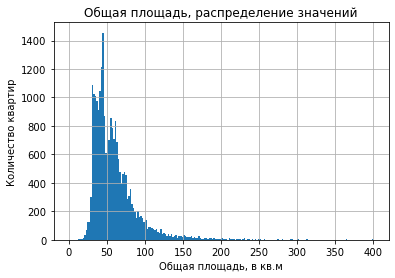

In [21]:
df['total_area'].hist(bins=200, range=(0, 400))
plt.xlabel('Общая площадь, в кв.м')
plt.ylabel('Количество квартир')
plt.title('Общая площадь, распределение значений')
plt.show()

Межквартильный размах Q3-Q1 по данной гистограмме равен 69.7 - 40.0 = 29.7
Значит, правый ус должен простираться до 69.7 + 1.5 * 29.7 = 114.25
Тогда все значения в total_area свыше 114.25 мы можем признать выбросами и не учитывать при дальнейших расчетах (около 5%)

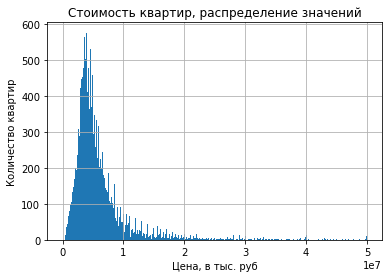

In [22]:
df['last_price'].hist(bins=500, range=(0, 50000000))
plt.xlabel('Цена, в тыс. руб')
plt.ylabel('Количество квартир')
plt.title('Стоимость квартир, распределение значений')
plt.show()
#если мы пойдем таким же путем, как и выше, то выбросов не найдем. Лишь сделаем вывод, что чем дальше значения от медианного
# - тем меньше их количество

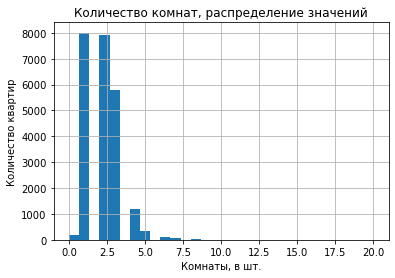

In [23]:
df['rooms'].hist(bins=30, range=(0, 20))
plt.xlabel('Комнаты, в шт.')
plt.ylabel('Количество квартир')
plt.title('Количество комнат, распределение значений')
plt.show()

В describe видим, что есть выбивающиеся максимальные значения, и отсечем их.
Межквартильный размах Q3-Q1 по данной гистограмме равен 3 - 1 = 2.
Значит, правый ус должен простираться до 3 + 1.5 * 2 = 6.
Тогда все значения в rooms свыше 6 мы можем признать выбросами и не учитывать при дальнейших расчетах (менее 1%)

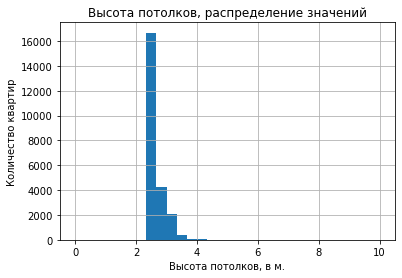

In [24]:
df['ceiling_height'].hist(bins=30, range=(0, 10))
plt.xlabel('Высота потолков, в м.')
plt.ylabel('Количество квартир')
plt.title('Высота потолков, распределение значений')
plt.show()

Тут по здравом размышлении можем признать выбросами все значения свыше 4 метров (менее 1%)

In [25]:
len(df.query('ceiling_height > 4')) / len(df)

0.003182686187141948

В итоге в целях для дальнейшего исследования будем работать с таблицей без выбросов

In [26]:
good_df = df.query('total_area <= 114.25 & rooms <= 6 & ceiling_height <= 4')
display('Доля неиспользуемых в дальнейшем выбросов составило {:%}'.format(1 - (len(good_df) / len(df))))

'Доля неиспользуемых в дальнейшем выбросов составило 5.499682%'

Пропущенные значения в столбце days_exposition могут говорить о том, что квартира на текущий момент не продана; заполним их медианой

count    22269.000000
mean       164.256770
std        200.950102
min          1.000000
25%         45.000000
50%         92.000000
75%        193.000000
max       1580.000000
Name: days_exposition, dtype: float64

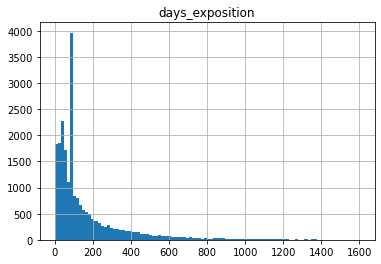

In [27]:
good_df['days_exposition'] = good_df['days_exposition'].fillna(good_df['days_exposition'].median())
good_df.hist('days_exposition', bins=100, range=(0, 1600))
#display(df['days_exposition'].value_counts(ascending=False))
good_df['days_exposition'].describe()

Из увиденного можем сделать следующие выводы:
- в среднем продажа квартиры занимает 164 дня, но важно учитывать, что среднее почти в 2 раза больше медианы + стандартное отклонение довольно велико (из-за длинного хвоста высоких значений), поэтому за нормальное значение примем время в 92 дня
- быстрая продажа - это когда квартира продается за месяц
- медленная - несколько лет (тут влияет много факторов: расположение, площадь, соседи и тд)

In [28]:
good_df['last_price'].corr(good_df['total_area'])

0.6825253098328197

При прочих равных, разумеется, цена квартиры напрямую зависит от ее общей площади и должна стремится к единице. Но в нашем случае существуют и дополнительные факторы, которые определяют цену. Поэтому показатель корреляции в 0.68 выглядит естественно.

In [29]:
good_df['last_price'].corr(good_df['rooms'])

0.3846269344541944

Коэффициент в 0.38 говорит о совсем не сильной зависимости цены квартиры от количества комнат (общая площадь важнее) 

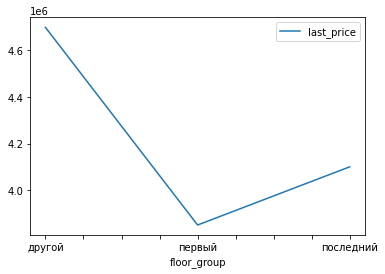

In [30]:
price_for_floor_group = good_df.groupby('floor_group').agg({'last_price': 'median'})
price_for_floor_group.plot()
plt.show()

На графике выше видим нелинейную зависимость: цена на первом этаже -  самая низкая

In [31]:
good_df['last_price'].corr(good_df['weekday'])

-0.016223704273438326

In [32]:
good_df['last_price'].corr(good_df['month'])

0.0002512728207686292

In [33]:
good_df['last_price'].corr(good_df['year'])

-0.009931374530284772

По приведенным выше формулам можем сделать вывод, что зависимость цены от дня, месяца и года продажи нет. 
Далее рассмотрим 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим населённые пункты с самой высокой и низкой стоимостью жилья

Предварительно видим, что у нас задваиваются/затраиваются значения в locality_name из-за того ,что названия дублируются: где-то наименование населенного пункта указано как Мурино, в других случаях = поселок Мурино / посёлок Мурино. Думается, что можно отбросить из строк названия населенных пунктов.

In [34]:
good_df['locality_name_2'] = good_df['locality_name'].str.replace('коттеджный|городской|посёлок|поселок|село|деревня', '')
good_df[['locality_name_2', 'locality_name']].drop_duplicates()

,locality_name_2,locality_name
0,Санкт-Петербург,Санкт-Петербург
1,Шушары,посёлок Шушары
5,Янино-1,городской посёлок Янино-1
6,Парголово,посёлок Парголово
8,Мурино,посёлок Мурино
...,...,...
22935,Володарское,поселок Володарское
23048,Лесное,коттеджный посёлок Лесное
23354,Тихковицы,деревня Тихковицы
23411,Борисова Грива,деревня Борисова Грива


In [35]:
top10_local_ads = good_df.groupby('locality_name_2')\
.agg({'first_day_exposition': 'count', 'price_for_meter': 'mean', 'last_price': ['max', 'min']})\
.sort_values(by= ('first_day_exposition', 'count'), ascending=False).head(10)
display(top10_local_ads)

first_day_exposition price_for_meter  last_price           
                               count            mean         max        min
locality_name_2                                                            
Санкт-Петербург                14469   110641.683670  82000000.0    12190.0
 Мурино                          550    85603.644853   8500000.0  1730000.0
 Шушары                          436    78578.068204  10990000.0  1500000.0
Всеволожск                       394    68624.345596  24412900.0   965780.0
Пушкин                           346   101885.259486  16912000.0  1990000.0
Колпино                          336    75370.025473  12750000.0  2100000.0
 Парголово                       326    90332.263023   9140000.0  1400000.0
Гатчина                          303    68931.687349  13900000.0   850000.0
 Кудрово                         298    92409.726322  10500000.0  1800000.0
Выборг                           227    58176.073433   8000000.0   600000.0

Теперь нам нужно определить, какая область входит в центр Питера.
Для этого отберем только питерские квартиры, переведем расстояние до центра в километры и по графику сделаем вывод

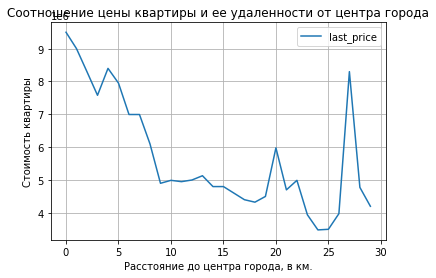

In [36]:
spb_ads = good_df[good_df['locality_name_2'] == "Санкт-Петербург"]
spb_ads['cityCenter_km'] = spb_ads['cityCenters_nearest'] // 1000
spb_ads.groupby('cityCenter_km').agg({'last_price': 'median'}).plot(grid=True)
plt.xlabel('Расстояние до центра города, в км.')
plt.ylabel('Стоимость квартиры')
plt.title('Соотношение цены квартиры и ее удаленности от центра города')
plt.show()

Из графика видим, что цена начинает стремительно уменьшаться, начиная с 5 км.
Делаем вывод, что именно эта область центром и является

In [37]:
spb_ads_center = spb_ads[spb_ads['cityCenter_km'] < 5.0]

Теперь сравним некоторые параметры по всей выборке spb_ads и spb_ads_center

In [38]:
for col in spb_ads[['cityCenters_nearest', 'rooms', 'floor']]:
    display(spb_ads['last_price'].corr(spb_ads[col]))

-0.3769130772017391

0.4074860725147096

0.024150323654720886

In [39]:
for col in spb_ads_center[['cityCenters_nearest', 'rooms', 'floor']]:
    display(spb_ads_center['last_price'].corr(spb_ads_center[col]))

-0.08185885949930784

0.192587726672647

0.11777655689809953

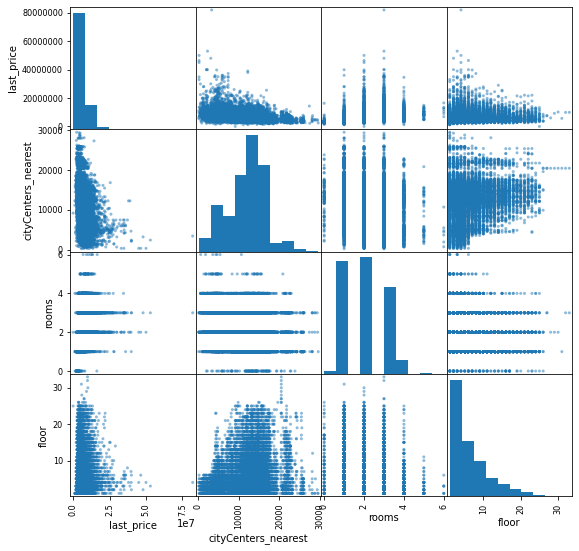

In [40]:
spb_ads_sample = spb_ads[['last_price', 'cityCenters_nearest', 'rooms', 'floor']]
pd.plotting.scatter_matrix(spb_ads_sample, figsize=(9, 9))
plt.show()

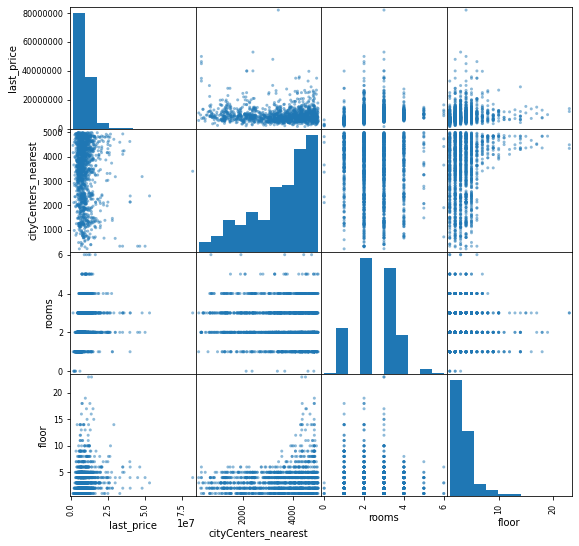

In [41]:
spb_ads_center_sample = spb_ads_center[['last_price', 'cityCenters_nearest', 'rooms', 'floor']]
pd.plotting.scatter_matrix(spb_ads_center_sample, figsize=(9, 9))
plt.show()


Из вычислений делаем следующий вывод: факторы, влияющие на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления) довольно слабо отличаются от общих выводов по всему городу

## Общий вывод
<a id='4'></a>

Подвод итог, можно сказать следующее. В целом на стоимость квартир влияет множество факторов. Основные - близость к центру и количество комнат (чем дальше от центра - тем СИЛЬНЕЕ корреляция с ценой), а также этаж (чем дальше от центра - тем СЛАБЕЕ корреляция с ценой)